Master Blockchain y Big Data. 
Universidad Complutense de Madrid.

En Septiembre de 2020

## Modelo de red neuronal convolucional para la clasificación de razas de perro. 


El objetivo principal de este notebook es el entrenamiento de un modelo que sea capaz de llevar a cabo la tarea del reconocimiento de imagenes, para la identificación de las 120 razas de perro utilizadas en el dataset Standford Dog DataSet. Este conjunto de datos se ha creado utilizando imágenes y anotaciones de ImageNet para la tarea de categorización detallada de imágenes, y se puede obtener del siguiente sitio web: https://www.kaggle.com/jessicali9530/stanford-dogs-dataset

De manera que, se han utilizado 120 categorias de perro y 22.580 imagenes, distribuidas en 9960 imagenes para el conjunto de prueba y 10620 para el conjunto de entrenamiento. 

### Indice

1. Análisis exploratorio de los datos.
2. Estudio de los mejores modelos de redes neuronales convolucionales.
3. Definición y entrenamiento de los modelos.
4. Comparación de los modelos y selección del mejor modelo.
5. Predicciones con el conjunto de prueba.

In [4]:
import tensorflow as fl
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
import pandas as pd
import numpy as np
from numpy import expand_dims
import os
import sys
import re
import shutil
import keras
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_nasnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inceptionResNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import logging
from random import randrange
import pydot
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from IPython.core.display import HTML
import collections
import math
import os
import time
from PIL import Image

logging.getLogger().setLevel(logging.INFO)


### 1. Análisis exploratorio de los datos

A continuación, se prodece a la realización del análisis exploratorio de los datos del conjunto de entrenamiento. Es importante comentar que, para la obtención del conjunto de entrenamiento y del conjunto de prueba, se ha llevado a cabo la realización de un script que añade 83 imágenes de cada categoría a la carpeta Images_test. El path de dicha carpeta se utilizará posteriormente para realizar las predicciones sobre el conjunto de prueba, es decir, sobre imágenes de distintas razas de perro que lógicamente no se van a utilizar para entrenar los módelos.

In [17]:
#Obtenemos el directorio del dataset de imagenes
datasetPath = "/home/ec2-user/images/Images"

#Vamos a explorar las diferentes imagenes, clases que tenemos en el directorio
logging.info(" Directorio del dataset de imagenes: " + datasetPath)

#Lista de tuplas donde guardaremos los nombres de los directorios encontrados
#y la cantidad de imagenes de cada uno, es decir, (nombreDir, listaArchivos)
classes = []
count = 0
data = []

logging.info(" Buscando la informacion del dataset")
for root, dirnames, filenames in os.walk(datasetPath):
    if(not classes):
        classes = dirnames
        continue
    data.append((classes[count],filenames))
    count+=1

logging.info(" Numero de clases: " + str(len(classes)) + " con nombres: " + str(classes))

allFiles = 0
count = 0
for dat in data:
    logging.info(" Numero de imagenes de la clase " + dat[0] + ": " + str(len(dat[1])))
    allFiles += len(dat[1])

logging.info(" Numero de imagenes de todas las clases en total: " + str(allFiles))
logging.info(" ------------------- FIN de exploracion de datos -------------------")

INFO:root: Directorio del dataset de imagenes: /home/ec2-user/images/Images
INFO:root: Buscando la informacion del dataset
INFO:root: Numero de clases: 120 con nombres: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier'

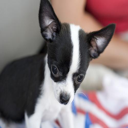

In [18]:
#Mostramos una imagen:
im =Image.open('/home/ec2-user/images/Images/n02085620-Chihuahua/n02085620_3826.jpg').resize((128,128))
im

### 2. Estudio de los mejores modelos CNN

Para conseguir el objetivo propuesto, se va a proceder a elegir los mejores modelos preentrenados. Todo ello se va a realizar comparando el comportamiento de los modelos que nos ofrece keras sobre el dataset utilizado. De manera que, va a ser necesario observar ***Top-1 Accuracy* y *Top-5 Accuracy***, proporcionados en la pagina ofical de keras (https://keras.io/api/applications/), para la elección de los dos mejores.

| Model | Size | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth |
|:---:|:---:|:---:|:---:|:---:|:---:|
| Xception | 88 MB | 0.790 | 0.945 | 22.910.480 | 126 |
| VGG16 | 582 MB | 0.713 | 0.901 | 138.357.544 | 23 |
| VGG19 | 549 MB | 0.713 | 0.900 | 143.667.240 | 26 |
| ResNet50 | 98 MB | 0.749 | 0.921 | 25.636.712 | - |
| ResNet101 | 171 MB | 0.764 | 0.928 | 44.707.176 | - |
| ResNet152 | 232 MB | 0.766 | 0.931 | 60.419.944 | - |
| ResNet50V2 | 98 MB | 0.760 | 0.930 | 25.613.800 | - |
| ResNet101V2 | 171 MB | 0.772 | 0.938 | 44.675.560 | - |
| ResNet152V2 | 232 MB | 0.780 | 0.942 | 60.380.648 | - |
| InceptionV3 | 92 MB | 0.779 | 0.937 | 23.851.784 | 159 |
| InceptionResNetV2 | 215 MB | 0.803 | 0.953 | 55.873.763 | 572 |
| MobileNet | 16 MB | 0.704 | 0.895 | 4.253.864 | 88 |
| MobileNetV2 | 14 MB | 0.713 | 0.901 | 3.538.984 | 88 |
| DenseNet121 | 33 MB | 0.750 | 0.923 | 8.062.504 | 121 |
| DenseNet169 | 57 MB | 0.762 | 0.932 | 14.307.880 | 169 |
| DenseNet201 | 80 MB | 0.773 | 0.936 | 20.242.984 | 201 |
| NASNetMobile | 23 MB | 0.744 | 0.919 | 5.326.716 | - |
| NASNetLarge | 343 MB | 0.825 | 0.960 | 88.949.818| - |

Por lo que, observando la tabla, vamos a obtener modelos para los modelos preentrenados: **VGG16, InceptionResNetV2, MobileNetV2.** Ya que, según la pagina oficial de keras, se corresponden con los mejores modelos.

### 3. Definicion y entrenamiento de los modelos

En el presente apartado se procedera a la definición y entrenamiento de los modelos seleccionados: VGG16, InceptionResNetV2, y MobileNetV2. De manera que, es necesario tener en cuenta que, al ser modelos preentrenados, sera necesario eliminar la ultima capa de cada uno de ellos para adaptarla a los requerimientos de nuestro objetivo principal. Para ello, se define el  atributo ***include_top*** a False.

Esta última capa para nuestros modelos, será una capa oculta (utilizando la función ***Dense***) donde utilizaremos los parámetros ***units y activation***. Estos dos parámetros obtendrán el valor ***128 y 'softmax'***. Estos valores son debidos al número de clases que tenemos que identificar en nuestro dataset y, por el otro lado, la función ***softmax***, nos permite obtener una probabilidad de a qué clase de raza pertenece la imagen a identificar, es decir, es la capa que identificará el tipo de raza de perro que tenemos en la imagen según los resultados que obtiene de las capas anteriores de la red.

No obstante, no hay que olvidar que es necesario aplanar la última convolución de la red preentrenada. Para conseguir este objetivo, añadiremos 2 capas anteriores a la última capa, es decir, vamos a añadir 3 capas en total, las 2 capas entre el modelo preentrenado y la última capa.
La primera de las dos capas a añadir será utilizando el output del modelo preentrenado junto con la función ***GlobalAveragePooling2D*** para aplicar la agrupación promedio de las dimensiones espaciales.
La otra capa que añadimos, utilizará la función ***Dense***, como la última capa que añadimos al modelo, pero cambiaremos los parámetros. El primer parámetro lo estableceremos a **512**, es decir, será una capa con 512 nodos en ella y se aplicará la *activation* **relu** en la capa. Esta función es un rectificador lineal que busca eliminar los valores negativos y dejar los positivos tal y como entran, es la función de activación más usada en el deep learning y, especialmente, en los trabajos con imágenes.

Es importante comentar, que esta estructura de la definición de los modelos se implementará con cada uno de los distintos modelos preentrenados seleccionados. 

#### 3.1. Modelo VGG16

Keras nos da la oportunidad de trabajar con redes convolucionales previamente preentrenadas para un objetivo generico, y posteriormente adaptarlas al problema de nuestro interes. Tal y como se ha comprobado en la pagina oficial de Keras, el modelo VGG16, es uno de los mejores. Esto es debido a que presenta las siguientes caracteristicas:

- Tiene una arquitectura fácil de comprender y, en su caso, de implementar.

- Logra un excelente resultado en la competencia ImageNet (ILSVRC-2014), entre el 96% y 97%.

- Contienen relativamente pocas capas convolucionales: 13 capas convolucionales y 3 densas, de ahí que en sus nombre incluya el 16.

VGG16 fue entrenada para resolver el problema de clasificación de 1000 clases en ImageNet, debe en sus pesos codificar información para extraer rasgos de muy distintas classes de representradas en las mas de 1.4 millones de fotografías de ImageNet. Por ello, VGG16 es una muy buena candidata para ser particularizada al problema de identificacion de razas de perros. 

In [19]:
#Modelo preentrenado VGG16
logging.info("Obtenemos el modelo base VGG16 sin la ultima capa")
modelVGG16_base=VGG16(weights='imagenet',include_top=False)
modelVGG16_base.trainable=False
x=modelVGG16_base.output
#Primera capa con el output de la ultima capa
logging.info("Primera capa con el output de la ultima capa")
x=GlobalAveragePooling2D()(x)
#dense layer 3 crea una nueva capa oculta con 512 nodos con activacion relu
logging.info("Segunda capa oculta con 512 nodos con activacion relu")
x=Dense(512,activation='relu')(x) 
#Creamos la ultima capa con 120 neuronas 
#las 120 razas de perros que queremos identificar)
#y aplicamos la activacion softmax
logging.info("Ultima capa")
preds=Dense(120,activation='softmax')(x) #final layer with softmax activation
#Creamos el modelo con las nuevas capas
logging.info("Generamos el modelo con las capas nuevas")
modelVGG16=Model(inputs=modelVGG16_base.input,outputs=preds)

INFO:root:Obtenemos el modelo base VGG16 sin la ultima capa


58892288/58889256 [==============================] - 1s 0us/step


INFO:root:Primera capa con el output de la ultima capa
INFO:root:Segunda capa oculta con 512 nodos con activacion relu
INFO:root:Ultima capa
INFO:root:Generamos el modelo con las capas nuevas


In [20]:
modelVGG16.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [21]:
logging.info("Numero de capas totales: " + str(len(modelVGG16.layers)))

INFO:root:Numero de capas totales: 22


In [22]:
logging.info("Establecemos las capas del modelo preentrenado a NO entrenables")
for layer in modelVGG16.layers[:19]:
    layer.trainable=False
    
logging.info("Establecemos las capas nuevas a entrenables")
for layer in modelVGG16.layers[19:]:
    layer.trainable=True

INFO:root:Establecemos las capas del modelo preentrenado a NO entrenables
INFO:root:Establecemos las capas nuevas a entrenables


In [23]:
logging.info("Utilizando ImageDataGenerator")
train_datagen = ImageDataGenerator(  
    preprocessing_function=preprocess_vgg16,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True)

logging.info("Generando el train_generator")
train_generator=train_datagen.flow_from_directory(path, 
                                                  target_size=(256,256),
                                                  # default parameters
                                                  color_mode='rgb',
                                                  batch_size=4,
                                                  class_mode='categorical',
                                                  shuffle=True)

INFO:root:Utilizando ImageDataGenerator
INFO:root:Generando el train_generator


Found 10620 images belonging to 120 classes.


In [27]:
logging.info("Compilando el modelo")
modelVGG16.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
logging.info("Comienzo de entrenamiento")
step_size_train=train_generator.n//train_generator.batch_size
model = modelVGG16.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=20)


INFO:root:Compilando el modelo
INFO:root:Comienzo de entrenamiento


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2655/2655 [==============================] - 1059s 399ms/step - loss: 0.6733 - accuracy: 0.8283
Epoch 2/20
2655/2655 [==============================] - 1059s 399ms/step - loss: 0.7151 - accuracy: 0.8283
Epoch 3/20
2655/2655 [==============================] - 1059s 399ms/step - loss: 0.6755 - accuracy: 0.8287
Epoch 4/20
2655/2655 [==============================] - 1062s 400ms/step - loss: 0.6658 - accuracy: 0.8335
Epoch 5/20
2655/2655 [==============================] - 1062s 400ms/step - loss: 0.6374 - accuracy: 0.8404
Epoch 6/20
2655/2655 [==============================] - 1064s 401ms/step - loss: 0.6546 - accuracy: 0.8423
Epoch 7/20
2655/2655 [==============================] - 10

In [41]:
modelVGG16.save("/home/ec2-user/Notebooks/modelo_vgg16_tfm.h5")

In [82]:
modelVGG16.save("/home/ec2-user/Notebooks/modelo_vgg16_tfm.py")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: /home/ec2-user/Notebooks/modelo_vgg16_tfm.py/assets


INFO:tensorflow:Assets written to: /home/ec2-user/Notebooks/modelo_vgg16_tfm.py/assets


#### 3.2 Modelo InceptionResNetV2

InceptionResNetV2 es una red neuronal convolucional que se entrena en más de un millón de imágenes de la base de datos ImageNet. La red tiene 164 capas de profundidad y puede clasificar imágenes en 1000 categorías de objetos, como teclado, mouse, lápiz y muchos animales. Como resultado, la red ha aprendido representaciones de características ricas para una amplia gama de imágenes. La red tiene un tamaño de entrada de imagen de 299 por 299. 
Para conocer la información de los parámetros necesarios para la definición de este modelo, podemos consultarlos en la página oficial de keras: https://keras.io/api/applications/inceptionresnetv2/

In [64]:
#Modelo preentrenado InceptionResNetV2
logging.info("Obtenemos el modelo base InceptionResNetV2 sin la ultima capa")
modelInceptionResNetV2_base = keras.applications.resnet_v2.ResNet50V2(weights='imagenet', include_top=False)
modelInceptionResNetV2_base.trainable=False
x=modelInceptionResNetV2_base.output
logging.info("Primera capa con el output de la ultima capa")
x=GlobalAveragePooling2D()(x)
#dense layer 3 crea una nueva capa oculta con 512 nodos con activacion relu
logging.info("Segunda capa oculta con 512 nodos con activacion relu")
x=Dense(512,activation='relu')(x) 
#Crea la ultima capa con 3 nodos y activacion softmax
logging.info("Ultima capa")
preds=Dense(120,activation='softmax')(x) #final layer with softmax activation
logging.info("Generamos el modelo con las capas nuevas")
modelInceptionResNetV2=Model(inputs=modelInceptionResNetV2_base.input,outputs=preds)

INFO:root:Obtenemos el modelo base InceptionResNetV2 sin la ultima capa
INFO:root:Primera capa con el output de la ultima capa
INFO:root:Segunda capa oculta con 512 nodos con activacion relu
INFO:root:Ultima capa
INFO:root:Generamos el modelo con las capas nuevas


In [65]:
modelInceptionResNetV2.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [66]:
logging.info("Numero de capas totales: " + str(len(modelInceptionResNetV2.layers)))

INFO:root:Numero de capas totales: 193


In [67]:
logging.info("Establecemos las capas del modelo preentrenado a NO entrenables")
for layer in modelInceptionResNetV2.layers[:190]:
    layer.trainable=False
logging.info("Establecemos las capas nuevas a entrenables")
for layer in modelInceptionResNetV2.layers[190:]:
    layer.trainable=True

INFO:root:Establecemos las capas del modelo preentrenado a NO entrenables
INFO:root:Establecemos las capas nuevas a entrenables


In [68]:
logging.info("Utilizando ImageDataGenerator")
train_datagen = ImageDataGenerator(  
    preprocessing_function=preprocess_inceptionResNetV2,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True)

logging.info("Generando el train_generator")
train_generator=train_datagen.flow_from_directory(path, # this is where you specify the path to the main data folder
                                                  target_size=(224,224),
                                                  # default parameters
                                                  color_mode='rgb',
                                                  batch_size=2,
                                                  class_mode='categorical',
                                                  shuffle=True)

INFO:root:Utilizando ImageDataGenerator
INFO:root:Generando el train_generator


Found 10620 images belonging to 120 classes.


In [70]:
logging.info("Compilando el modelo")
modelInceptionResNetV2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
logging.info("Comienzo de entrenamiento")
step_size_train=train_generator.n//train_generator.batch_size
modelInceptionResNetV2.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=20)

INFO:root:Compilando el modelo
INFO:root:Comienzo de entrenamiento


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5310/5310 [==============================] - 369s 69ms/step - loss: 0.9341 - accuracy: 0.7515
Epoch 2/20
5310/5310 [==============================] - 369s 69ms/step - loss: 0.8763 - accuracy: 0.7664
Epoch 3/20
5310/5310 [==============================] - 368s 69ms/step - loss: 0.8536 - accuracy: 0.7745
Epoch 4/20
5310/5310 [==============================] - 367s 69ms/step - loss: 0.8376 - accuracy: 0.7866
Epoch 5/20
5310/5310 [==============================] - 368s 69ms/step - loss: 0.7926 - accuracy: 0.7893
Epoch 6/20
5310/5310 [==============================] - 367s 69ms/step - loss: 0.7865 - accuracy: 0.8005
Epoch 7/20
5310/5310 [==============================] - 368s 69ms/step

In [75]:
modelInceptionResNetV2.save('/home/ec2-user/Notebooks/InceptionResNetV2.h5')
modelInceptionResNetV2.save('/home/ec2-user/Notebooks/InceptionResNetV2.py')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: /home/ec2-user/Notebooks/InceptionResNetV2.py/assets


INFO:tensorflow:Assets written to: /home/ec2-user/Notebooks/InceptionResNetV2.py/assets


#### 3.3 Modelo MobileNetV2

MobileNet-v2 es una red neuronal convolucional que tiene 53 capas de profundidad. Puede cargar una versión preentrenada de la red entrenada en más de un millón de imágenes de la base de datos ImageNet [1]. La red previamente entrenada puede clasificar imágenes en 1000 categorías de objetos. Como resultado, la red ha aprendido representaciones de características ricas para una amplia gama de imágenes. Por lo que también puede resultar ser bastante interesante para el desarrollo e implementación de nuestro algoritmo objetivo.

Para visualizar la información referente a los parámetros definidos en este modelo, consultar el siguiente enlace:
https://keras.io/api/applications/mobilenet/

In [53]:
#Modelo preentrenado MobileNetV2
logging.info("Obtenemos el modelo base MobileNetV2 sin la ultima capa")
modelMobileNetV2_base = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)
modelMobileNetV2_base.trainable=False
x=modelMobileNetV2_base.output
logging.info("Primera capa con el output de la ultima capa")
x=GlobalAveragePooling2D()(x)
logging.info("Segunda capa oculta con 512 nodos con activacion relu")
#dense layer 3 crea una nueva capa oculta con 512 nodos con activacion relu
x=Dense(512,activation='relu')(x) 
#Crea la ultima capa con 3 nodos y activacion softmax
logging.info("Ultima capa")
preds=Dense(120,activation='softmax')(x) #final layer with softmax activation
logging.info("Generamos el modelo con las capas nuevas")
modelMobileNetV2=Model(inputs=modelMobileNetV2_base.input,outputs=preds)

INFO:root:Obtenemos el modelo base MobileNetV2 sin la ultima capa


9412608/9406464 [==============================] - 0s 0us/step


INFO:root:Primera capa con el output de la ultima capa
INFO:root:Segunda capa oculta con 512 nodos con activacion relu
INFO:root:Ultima capa
INFO:root:Generamos el modelo con las capas nuevas


In [54]:
modelMobileNetV2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [119]:
logging.info("Numero de capas totales: " + str(len(modelMobileNetV2.layers)))

INFO:root:Numero de capas totales: 158


In [55]:
logging.info("Establecemos las capas del modelo preentrenado a NO entrenables")
for layer in modelMobileNetV2.layers[:155]:
    layer.trainable=False
logging.info("Establecemos las capas nuevas a entrenables")
for layer in modelMobileNetV2.layers[155:]:
    layer.trainable=True

INFO:root:Establecemos las capas del modelo preentrenado a NO entrenables
INFO:root:Establecemos las capas nuevas a entrenables


In [56]:
logging.info("Utilizando ImageDataGenerator")

train_datagen = ImageDataGenerator(  
    preprocessing_function=preprocess_mobilenet,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True)

logging.info("Generando el train_generator")
train_generator=train_datagen.flow_from_directory(path, # this is where you specify the path to the main data folder
                                                  target_size=(224,224),
                                                  # default parameters
                                                  color_mode='rgb',
                                                  batch_size=2,
                                                  class_mode='categorical',
                                                  shuffle=True)

INFO:root:Utilizando ImageDataGenerator
INFO:root:Generando el train_generator


Found 10620 images belonging to 120 classes.


In [58]:
logging.info("Compilando el modelo")
modelMobileNetV2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

logging.info("Comienzo de entrenamiento")
step_size_train=train_generator.n//train_generator.batch_size
modelMobileNetV2.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=20)

INFO:root:Compilando el modelo
INFO:root:Comienzo de entrenamiento


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5310/5310 [==============================] - 213s 40ms/step - loss: 1.2467 - accuracy: 0.6503
Epoch 2/20
5310/5310 [==============================] - 212s 40ms/step - loss: 0.9041 - accuracy: 0.7337
Epoch 3/20
5310/5310 [==============================] - 212s 40ms/step - loss: 0.7751 - accuracy: 0.7717
Epoch 4/20
5310/5310 [==============================] - 212s 40ms/step - loss: 0.6829 - accuracy: 0.7987
Epoch 5/20
5310/5310 [==============================] - 213s 40ms/step - loss: 0.6420 - accuracy: 0.8146
Epoch 6/20
5310/5310 [==============================] - 214s 40ms/step - loss: 0.5777 - accuracy: 0.8347
Epoch 7/20
5310/5310 [==============================] - 212s 40ms/step

In [74]:
modelMobileNetV2.save('/home/ec2-user/Notebooks/modelMobileNetV2.h5')
modelMobileNetV2.save('/home/ec2-user/Notebooks/modelMobileNetV2.py')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: /home/ec2-user/Notebooks/modelMobileNetV2.py/assets


INFO:tensorflow:Assets written to: /home/ec2-user/Notebooks/modelMobileNetV2.py/assets


### 4. Comparación de los modelos y selección del mejor modelo.

A continuación, se muestra una tabla con la precisión obtenida por los diferentes modelos entrenados, únicamente se muestra la precisión obtenida en la etapa 20, es decir, la última precisión obtenida:

| Modelo | Precisión |
|:--:|:---:|
| VGG16 | 0.87 |
| InceptionResNetV2 | 0.87 |
| MobileNetV2 | 0.92 |


Se observa como claramente el modelo que utiliza la red preentrenada **MobileNetV2** obtiene una precisión bastante superior a todos los demás modelos estudiados, **por lo que elegimos esta modelo como ganador**.

### 5. Predicciones con el conjunto de prueba.

Después de haber seleccionado el mejor modelo, se procede a continuación a su evaluación y a la elavoración de las predicciones del conjunto de prueba.

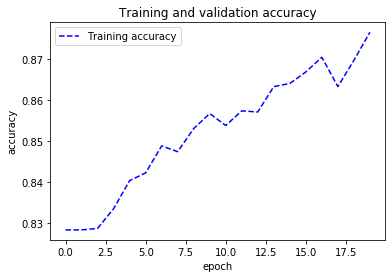

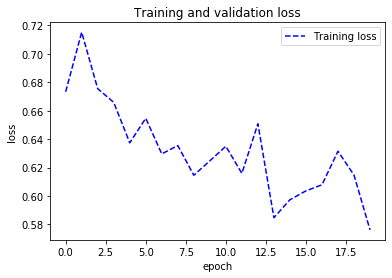

In [81]:
#Evaluamos el modelo

import matplotlib.pyplot as plt
%matplotlib inline

accuracy = model.history['accuracy']
loss =  model.history['loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b--', label='Training accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

Vamos a utilizar nuestro modelo para predecir las imágenes que hemos guardado anteriormente, las cuales no han sido utilizadas en el entrenamiento del modelo. 

In [79]:
class_dict = {v:k for k, v in train_generator.class_indices.items()}

def predict_image(path):
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_mobilenet(data)
    preds = modelMobileNetV2.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    print(pred)
    return img

In [77]:
path_test = "/home/ec2-user/images/Images_test/"
dogs_labels_test = set()
for d in os.listdir(path_test):
    dogs_labels_test.add(d)
    
dogs_labels_test = list(dogs_labels_test)
dogs_labels_path_test = [path_test + s for s in dogs_labels_test]
dogs_labels_path_test

['/home/ec2-user/images/Images_test/n02088632_2454.jpg',
 '/home/ec2-user/images/Images_test/n02093647_1428.jpg',
 '/home/ec2-user/images/Images_test/n02105056_4173.jpg',
 '/home/ec2-user/images/Images_test/n02087046_1792.jpg',
 '/home/ec2-user/images/Images_test/n02108000_2394.jpg',
 '/home/ec2-user/images/Images_test/n02090721_2235.jpg',
 '/home/ec2-user/images/Images_test/n02097209_2365.jpg',
 '/home/ec2-user/images/Images_test/n02094433_2197.jpg',
 '/home/ec2-user/images/Images_test/n02105251_6907.jpg',
 '/home/ec2-user/images/Images_test/n02097047_1412.jpg',
 '/home/ec2-user/images/Images_test/n02106382_1700.jpg',
 '/home/ec2-user/images/Images_test/n02113978_1653.jpg',
 '/home/ec2-user/images/Images_test/n02088632_1277.jpg',
 '/home/ec2-user/images/Images_test/n02099429_1759.jpg',
 '/home/ec2-user/images/Images_test/n02091032_1396.jpg',
 '/home/ec2-user/images/Images_test/n02093256_367.jpg',
 '/home/ec2-user/images/Images_test/n02099601_3738.jpg',
 '/home/ec2-user/images/Images_t

In [80]:
for ima in dogs_labels_path_test:
    predict_image(ima)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
n02088632-bluetick
n02093647-Bedlington_terrier
n02105056-groenendael
n02087046-toy_terrier
n02108000-EntleBucher
n02105251-briard
n02097047-miniature_schnauzer
n02094433-Yorkshire_terrier
n02105251-briard
n02097047-miniature_schnauzer
n02106382-Bouvier_des_Flandres
n02087394-Rhodesian_ridgeback
n02088632-bluetick
n02099429-curly-coated_retriever
n02091032-Italian_greyhound
n02093256-Staffordshire_bullterrier
n02099601-golden_retriever
n02085936-Maltese_dog
n02096294-Australian_terrier
n02111889-Samoyed
n02099429-curly-coated_retriever
n02107312-miniature_pinscher
n02102973-Irish_water_spaniel
n02098413-Lhasa
n02086240-Shih-Tzu
n02106166-Border_collie
n02110185-Siberian_husky
n020